### A nice Python function to help read data

We still need our helper function read_traffic

In [12]:
import subprocess
import datetime
import pandas as pd

def read_traffic(filename, fields=[], display_filter="", 
              timeseries=False, strict=False):
    """ Read PCAP file into Pandas DataFrame object. 
    Uses tshark command-line tool from Wireshark.

    filename:       Name or full path of the PCAP file to read
    fields:         List of fields to include as columns
    display_filter: Additional filter to restrict frames
    strict:         Only include frames that contain all given fields 
                    (Default: false)
    timeseries:     Create DatetimeIndex from frame.time_epoch 
                    (Default: false)

    Syntax for fields and display_filter is specified in
    Wireshark's Display Filter Reference:
 
      http://www.wireshark.org/docs/dfref/
    """
    if timeseries:
        fields = ["frame.time_epoch"] + fields
    fieldspec = " ".join("-e %s" % f for f in fields)

    display_filters = fields if strict else []
    if display_filter:
        display_filters.append(display_filter)
    filterspec = "-Y '%s'" % " and ".join(f for f in display_filters)

    options = "-r %s -n -T fields -Eheader=y" % filename
    cmd = "tshark %s %s %s" % (options, filterspec, fieldspec)
    #print cmd
    proc = subprocess.Popen(cmd, shell = True, 
                                 stdout=subprocess.PIPE)
    if timeseries:
        df = pd.read_table(proc.stdout, 
                        index_col = "frame.time_epoch", 
                        parse_dates=True, 
                        date_parser=datetime.datetime.fromtimestamp)
    else:
        df = pd.read_table(proc.stdout)
    return df

## Analyze the file 1n1_ovs1.pcap

In [13]:
fields=["tcp.stream", "ip.src", "tcp.srcport", "ip.dst", "tcp.dstport", "tcp.len", "tcp.time_delta"]
ts=read_traffic("1n1_ovs1.pcap", fields, timeseries=True, strict=True)
ts.head()

,tcp.stream,ip.src,tcp.srcport,ip.dst,tcp.dstport,tcp.len,tcp.time_delta
frame.time_epoch,,,,,,,
2016-10-03 16:31:00.018406,0,10.10.10.3,38224,10.10.10.1,1701,0,0.000000
2016-10-03 16:31:00.018906,0,10.10.10.1,1701,10.10.10.3,38224,0,0.000500
2016-10-03 16:31:00.022640,0,10.10.10.3,38224,10.10.10.1,1701,0,0.003734
2016-10-03 16:31:00.023226,0,10.10.10.1,1701,10.10.10.3,38224,1448,0.000586
2016-10-03 16:31:00.023750,0,10.10.10.3,38224,10.10.10.1,1701,0,0.000524


In [14]:
import numpy as np
ts['capture.time']=ts.index.to_datetime()
ts.head()

,tcp.stream,ip.src,tcp.srcport,ip.dst,tcp.dstport,tcp.len,tcp.time_delta,capture.time
frame.time_epoch,,,,,,,,
2016-10-03 16:31:00.018406,0,10.10.10.3,38224,10.10.10.1,1701,0,0.000000,2016-10-03 16:31:00.018406
2016-10-03 16:31:00.018906,0,10.10.10.1,1701,10.10.10.3,38224,0,0.000500,2016-10-03 16:31:00.018906
2016-10-03 16:31:00.022640,0,10.10.10.3,38224,10.10.10.1,1701,0,0.003734,2016-10-03 16:31:00.022640
2016-10-03 16:31:00.023226,0,10.10.10.1,1701,10.10.10.3,38224,1448,0.000586,2016-10-03 16:31:00.023226
2016-10-03 16:31:00.023750,0,10.10.10.3,38224,10.10.10.1,1701,0,0.000524,2016-10-03 16:31:00.023750


Now, we can group packets into streams.

In [15]:
grouped=ts.groupby("tcp.stream")
#grouped["capture.time"] = pd.to_datetime(grouped["capture.time"])

We then use group object's agg function to generate a new data frame, which is frame based. 

Note that we assume each stream's source ip, source port, destination ip, destination port are the same with those in the stream's first packet. It may not be 100% accurate in real-world.

In [16]:
streams=grouped.agg({'capture.time':[np.min, np.max],
            'ip.src':lambda x:x[0],
            'tcp.srcport':lambda x:x[0],
            'ip.dst':lambda x:x[0],
            'tcp.dstport':lambda x: x[0],
            'tcp.len':np.sum,
            'tcp.time_delta':np.mean})
streams["duration"] = streams["capture.time"]["amax"].sub(streams["capture.time"]["amin"])
streams["duration"] = streams["duration"].apply(lambda x: x.total_seconds())
streams = streams.drop("capture.time", axis=1, level=0)
streams['packets'] = grouped.count()["ip.src"]

streams.head()

,tcp.len,ip.dst,tcp.srcport,tcp.time_delta,tcp.dstport,ip.src,duration,packets
,sum,<lambda>,<lambda>,mean,<lambda>,<lambda>,,
tcp.stream,,,,,,,,
0,7345,10.10.10.1,38224,0.371260,1701,10.10.10.3,8.167714,22
1,1153,10.10.10.1,49178,0.024916,1700,10.10.10.3,0.249155,10
2,7345,10.10.10.3,53067,0.355309,1700,10.10.10.1,8.172102,23
3,1153,10.10.10.3,53068,0.025284,1700,10.10.10.1,0.252839,10
4,3492,10.10.10.1,49179,0.001055,1700,10.10.10.3,0.012659,12


Change the column names and the index name

In [17]:
streams.columns=['stream_len', 'dst_ip', 'src_port', 'mean_delay','dst_port','src_ip', 'duration', 'packets']
streams.index.rename('stream_id', inplace=True)
streams.head()

,stream_len,dst_ip,src_port,mean_delay,dst_port,src_ip,duration,packets
stream_id,,,,,,,,
0,7345,10.10.10.1,38224,0.371260,1701,10.10.10.3,8.167714,22
1,1153,10.10.10.1,49178,0.024916,1700,10.10.10.3,0.249155,10
2,7345,10.10.10.3,53067,0.355309,1700,10.10.10.1,8.172102,23
3,1153,10.10.10.3,53068,0.025284,1700,10.10.10.1,0.252839,10
4,3492,10.10.10.1,49179,0.001055,1700,10.10.10.3,0.012659,12


In [19]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler

X = streams.as_matrix(columns = ["stream_len", "duration", "mean_delay"])
X[:, 0] = StandardScaler().fit_transform(X[:, 0])


//anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:583: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
//anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:646: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


In [20]:
db = DBSCAN(eps=0.3, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)


Estimated number of clusters: 6


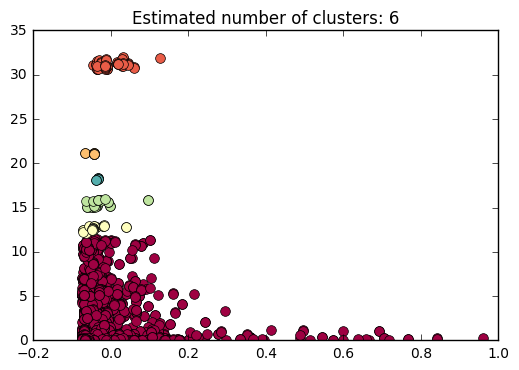

In [23]:
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], '.', markerfacecolor=col,
             markeredgecolor='k', markersize=14)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()